# BigMart Outletwise Product Sales Prediction

Bigmart has Outlets in various locations and selling close to 1500 products across 10 outlets in different cities.  BigMart would like to predict the product sales on the outlets to maximize their revenue.  

The data and the problem is available in the following link.  https://datahack.analyticsvidhya.com/contest/practice-problem-big-mart-sales-iii/

### Loading the required libraries and loading the data

In [1]:
## Importing required Libraries
import pandas as pd
import numpy as np

## Loading the data
bm_train = pd.read_csv("Train_data.csv")
bm_test = pd.read_csv("Test_data.csv")

## Prining the shape of data sets

print("Train Data Set: ",bm_train.shape)
print("Test Data Set: ",bm_test.shape)

Train Data Set:  (8523, 12)
Test Data Set:  (5681, 11)


It's always good idea to combine both data sets for missing value treatmens, feature engineering and data preprocessing and then separate it for modeling.  Now let us combine both datasets.

In [2]:
## Adding a source column to identify train and test datasets
bm_train['source'] = 'train'
bm_test['source'] = 'test'

## Combining both datasets
bm_data = pd.concat([bm_train,bm_test], ignore_index = True)

In [3]:
bm_train.shape

(8523, 13)

In [4]:
bm_test.shape

(5681, 12)

In [5]:
bm_data.shape

(14204, 13)

In [6]:
bm_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14204 entries, 0 to 14203
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            14204 non-null  object 
 1   Item_Weight                11765 non-null  float64
 2   Item_Fat_Content           14204 non-null  object 
 3   Item_Visibility            14204 non-null  float64
 4   Item_Type                  14204 non-null  object 
 5   Item_MRP                   14204 non-null  float64
 6   Outlet_Identifier          14204 non-null  object 
 7   Outlet_Establishment_Year  14204 non-null  int64  
 8   Outlet_Size                10188 non-null  object 
 9   Outlet_Location_Type       14204 non-null  object 
 10  Outlet_Type                14204 non-null  object 
 11  Item_Outlet_Sales          8523 non-null   float64
 12  source                     14204 non-null  object 
dtypes: float64(4), int64(1), object(8)
memory usag

In [7]:
## Now checking the null values
bm_data.apply(lambda x:sum(x.isnull()))

Item_Identifier                 0
Item_Weight                  2439
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  4016
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales            5681
source                          0
dtype: int64

Item_Weight and Outlet_Size have missing values.  Item_Outlet_Sales also have missing values, but it is from test dataset.  Hence we don't need to worry about them.

Let us check some basic statistics of the data.

In [8]:
## basic statistics of the data
bm_data.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,11765.000000,14204.000000,14204.000000,14204.000000,8523.000000
mean,12.792854,0.065953,141.004977,1997.830681,2181.288914
std,4.652502,0.051459,62.086938,8.371664,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.710000,0.027036,94.012000,1987.000000,834.247400
50%,12.600000,0.054021,142.247000,1999.000000,1794.331000
75%,16.750000,0.094037,185.855600,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


Some observations:

1. **Item_Visibility** has a min value of zero. This makes no practical sense because when a product is being sold in a store, the visibility cannot be 0.
2. **Outlet_Establishment_Years** vary from 1985 to 2009. The values might not be apt in this form. Rather, if we can convert them to how old the particular store is, it should have a better impact on sales.
3. The lower ‘count’ of Item_Weight and Item_Outlet_Sales confirms the findings from the missing value check.

Moving to nominal (categorical) variable, lets have a look at the number of unique values in each of them.

In [9]:
## Unique values of Categorical variables
bm_data.apply(lambda x: len(x.unique()))

Item_Identifier               1559
Item_Weight                    416
Item_Fat_Content                 5
Item_Visibility              13006
Item_Type                       16
Item_MRP                      8052
Outlet_Identifier               10
Outlet_Establishment_Year        9
Outlet_Size                      4
Outlet_Location_Type             3
Outlet_Type                      4
Item_Outlet_Sales             3494
source                           2
dtype: int64

As we seen in the problem statement, it has 1559 products and 10 outlets.  Now let us findout the frequecy of each category for categorical variables.

In [10]:
## Getting categorical variables
#cat_vars = [x for x in bm_data.dtypes.index if bm_data.dtypes[x] == 'object']
cat_vars = bm_data.select_dtypes(include = 'object').columns
cat_vars

Index(['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type', 'source'],
      dtype='object')

In [11]:
## Let us drop the unwanted columns
cat_vars = [x for x in cat_vars if x not in ['Item_Identifier','Outlet_Identifier','source']]

In [12]:
cat_vars

['Item_Fat_Content',
 'Item_Type',
 'Outlet_Size',
 'Outlet_Location_Type',
 'Outlet_Type']

In [13]:
## Now let us print out the frequecy of each categories in each categorical variable
for col in cat_vars:
    print("The Frequecies of Categorical Variable ",col)
    print(bm_data[col].value_counts())
    print("")

The Frequecies of Categorical Variable  Item_Fat_Content
Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: Item_Fat_Content, dtype: int64

The Frequecies of Categorical Variable  Item_Type
Fruits and Vegetables    2013
Snack Foods              1989
Household                1548
Frozen Foods             1426
Dairy                    1136
Baking Goods             1086
Canned                   1084
Health and Hygiene        858
Meat                      736
Soft Drinks               726
Breads                    416
Hard Drinks               362
Others                    280
Starchy Foods             269
Breakfast                 186
Seafood                    89
Name: Item_Type, dtype: int64

The Frequecies of Categorical Variable  Outlet_Size
Medium    4655
Small     3980
High      1553
Name: Outlet_Size, dtype: int64

The Frequecies of Categorical Variable  Outlet_Location_Type
Tier 3    5583
Tier 2    4641
Tier 1    3980
Name: Outlet_Location_Type, 

The output gives us following observations:

1. **Item_Fat_Content:** Some of ‘Low Fat’ values mis-coded as ‘low fat’ and ‘LF’. Also, some of ‘Regular’ are mentioned as ‘regular’.
2. **Item_Type:** Not all categories have substantial numbers. It looks like combining them can give better results.
3. **Outlet_Type:** Supermarket Type2 and Type3 can be combined. But we should check if that’s a good idea before doing it.

## Data Cleaning

This step typically involves imputing missing values,  treating outliers if any and updating the mis-spelled categories to correct categories.

### Imputing Missing Values

We found two variables with missing values – Item_Weight and Outlet_Size. Lets impute the former by the average weight of the particular item. This can be done as:

In [14]:
# Determine the average weight per item:
item_avg_weight = bm_data.pivot_table(values='Item_Weight', index=['Item_Identifier'])
item_avg_weight

,Item_Weight
Item_Identifier,
DRA12,11.600
DRA24,19.350
DRA59,8.270
DRB01,7.390
DRB13,6.115
...,...
NCZ30,6.590
NCZ41,19.850
NCZ42,10.500


In [1]:
#item_avg_weight.loc[('High','DRA12')]

In [ ]:
bm_data['Item_Weight'].mean()

In [19]:
## Getting the boolean values of missing Item_Weights
iw_bool = bm_data.Item_Weight.isnull()
print("Before imputing... ")
print("The Missing Value Count is : ",sum(iw_bool))

Before imputing... 
The Missing Value Count is :  2439


In [20]:
iw_bool[:5]

0    False
1    False
2    False
3    False
4    False
Name: Item_Weight, dtype: bool

In [21]:
bm_data.Item_Weight.mean()

12.792854228644991

In [22]:
## Imputing the missing Item_Weights by their mean of Item_Identifier
bm_data.loc[iw_bool,'Item_Weight'] = bm_data.loc[iw_bool,'Item_Identifier'].apply(lambda x: item_avg_weight.loc[x])

In [23]:
print("After imputing... ")
print("The Missing Value Count is : ", sum(bm_data.Item_Weight.isnull()))

After imputing... 
The Missing Value Count is :  0


In [24]:
item_avg_weight.loc['FDP10']

Item_Weight    19.0
Name: FDP10, dtype: float64

Now imputing the missing outlet size.  We will be using Outlet_Type to identify the Outlet_Size.

In [25]:
#Import mode function:
from scipy.stats import mode

#Determing the mode for each
outlet_size_mode = bm_data.pivot_table(values='Outlet_Size', columns='Outlet_Type',aggfunc=(lambda x:mode(x).mode[0]) )
print('Mode for each Outlet_Type:')
print(outlet_size_mode)

#Get a boolean variable specifying missing Item_Weight values
miss_bool = bm_data['Outlet_Size'].isnull() 

#Impute data and check #missing values before and after imputation to confirm
print('\nOrignal #missing: ', sum(miss_bool))
bm_data.loc[miss_bool,'Outlet_Size'] = bm_data.loc[miss_bool,'Outlet_Type'].apply(lambda x: outlet_size_mode[x])
print(sum(bm_data['Outlet_Size'].isnull()))

Mode for each Outlet_Type:
Outlet_Type Grocery Store Supermarket Type1 Supermarket Type2  \
Outlet_Size         Small             Small            Medium   

Outlet_Type Supermarket Type3  
Outlet_Size            Medium  

Orignal #missing:  4016
0


## Feature Engineering

### Combining Outlet Type

We can consider combining the Supermarket Type2 and Type3 variables by analyzing the mean sales by type of store. If they have similar sales, then keeping them separate won’t help much.

In [26]:
## Sales by Outlet_type

bm_data.pivot_table(values="Item_Outlet_Sales", index="Outlet_Type")

,Item_Outlet_Sales
Outlet_Type,
Grocery Store,339.828500
Supermarket Type1,2316.181148
Supermarket Type2,1995.498739
Supermarket Type3,3694.038558


There is significant difference in the Sales for each type of store.  Hence we can leave it as it is.

### Modifying the Item_Visibility

Earlier we have observed that the minimum value of Item_Visibility is zero, which can't be true.  How come a Store can sell an item without displaying the item.  SO we need to find out how many items has zero visibility and impute them.

In [27]:
## Determining the average visibility of a product
visibility_avg = bm_data.pivot_table(values='Item_Visibility', index = 'Item_Identifier')
print(visibility_avg)

                 Item_Visibility
Item_Identifier                 
DRA12                   0.034938
DRA24                   0.045646
DRA59                   0.133384
DRB01                   0.079736
DRB13                   0.006799
...                          ...
NCZ30                   0.027302
NCZ41                   0.056396
NCZ42                   0.011015
NCZ53                   0.026330
NCZ54                   0.081345

[1559 rows x 1 columns]


Similar to Item_Weight, we will impute the Item_Visibility too.  i.e, imputing the zero visibility items by average of their Item_Identifier.  

In [28]:
## Identifying the zero visibility items
visibility_bool = bm_data['Item_Visibility']==0
print("Total zero visibility Items : ",sum(visibility_bool))

Total zero visibility Items :  879


In [29]:
## Imputing the zero visibility

bm_data.loc[visibility_bool, 'Item_Visibility'] = bm_data.loc[visibility_bool, 'Item_Identifier'].apply(lambda x: visibility_avg.loc[x])
                                                                                                   
## Verifying if there is any zero visibilty after update
print("Total zero visibility Items after Update :", sum(bm_data['Item_Visibility'] == 0))                                                                                                

Total zero visibility Items after Update : 0


In [30]:
bm_data.Item_Visibility.isnull().sum()

0

### Creating Item_Visibility_MeanRatio variable

Hypothetically high visibility items in a store will sell more than low visibility items.  So, in a particular store, how an Item is visible when compared with same Item in all other type of stores, will give an idea of how an Item is sold in a particular store.  So, the Item_visibility_meanration will be a good variable to compute.

In [31]:
## Creating Item_Visibility_MeanRatio variable
bm_data['Item_Visibility_MeanRatio'] =   bm_data.apply(lambda x: x['Item_Visibility']/visibility_avg.loc[x['Item_Identifier']], axis=1)

## Checking basic statistics of the new variable
bm_data['Item_Visibility_MeanRatio'].describe()

count    14204.000000
mean         1.061884
std          0.235907
min          0.844563
25%          0.925131
50%          0.999070
75%          1.042007
max          3.010094
Name: Item_Visibility_MeanRatio, dtype: float64

In [32]:
bm_data['Item_Type'].value_counts()

Fruits and Vegetables    2013
Snack Foods              1989
Household                1548
Frozen Foods             1426
Dairy                    1136
Baking Goods             1086
Canned                   1084
Health and Hygiene        858
Meat                      736
Soft Drinks               726
Breads                    416
Hard Drinks               362
Others                    280
Starchy Foods             269
Breakfast                 186
Seafood                    89
Name: Item_Type, dtype: int64

### Creating Category of Items from Item_Identifier

Earlier we saw that the Item_Type variable has 16 categories which might prove to be very useful in analysis. So its a good idea to combine them. One way could be to manually assign a new category to each. If we look at the Item_Identifier, i.e. the unique ID of each item, it starts with either FD, DR or NC. It's look like categories of Food, Drinks and Non-Consumables. Hence we can use the Item_Identifier variable to create a new column Item_Category.

In [33]:
## Creating new column Item_Category
bm_data['Item_Category'] = bm_data['Item_Identifier'].str.slice(0,2).map({'FD':'Food',
                                             'DR':'Drinks',
                                             'NC':'Non-Consumable'})

## Counting each of them
bm_data.Item_Category.value_counts()


Food              10201
Non-Consumable     2686
Drinks             1317
Name: Item_Category, dtype: int64

In [34]:
bm_data.Outlet_Identifier.value_counts()

OUT027    1559
OUT013    1553
OUT049    1550
OUT046    1550
OUT035    1550
OUT045    1548
OUT018    1546
OUT017    1543
OUT010     925
OUT019     880
Name: Outlet_Identifier, dtype: int64

### Updating Item_Fat_Content

As sean earlier, there are typo error in Item_Fat_Content categories.  we will updating them now.

In [35]:
## Item_Fat_Content categories (Before Update)
bm_data.Item_Fat_Content.value_counts()

Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: Item_Fat_Content, dtype: int64

In [36]:
## Correcting Item_Fat_Content
bm_data['Item_Fat_Content'] = bm_data['Item_Fat_Content'].replace({'LF':'Low Fat',
                                                                  'reg':'Regular',
                                                                  'low fat':'Low Fat'})

## Item_Fat_Content categories (After Update)
bm_data.Item_Fat_Content.value_counts()

Low Fat    9185
Regular    5019
Name: Item_Fat_Content, dtype: int64

In our earlier step we noticed some non-edible items are also in the Item_Type.  So, we need to create a new category as 'Non Edible' in Item_Fat_Content.

In [37]:
## creating new category "Non-Edible" in Item_Fat_Content for Non-Consumable
bm_data.loc[bm_data['Item_Category'] == 'Non-Consumable', 'Item_Fat_Content'] = 'Non-Edible'

## Item_Fat_Content categories (After Update)
bm_data.Item_Fat_Content.value_counts()

Low Fat       6499
Regular       5019
Non-Edible    2686
Name: Item_Fat_Content, dtype: int64

### Creating Outlet_Years 

Let us create a new column depicting the years of operation of a store. This can be done as:

In [38]:
## Before creating the column
bm_data.Outlet_Establishment_Year.value_counts()

1985    2439
1987    1553
1999    1550
1997    1550
2004    1550
2002    1548
2009    1546
2007    1543
1998     925
Name: Outlet_Establishment_Year, dtype: int64

In [39]:
## Creating Years of operation of each store
bm_data['Outlet_Years'] = 2013 - bm_data.Outlet_Establishment_Year

In [40]:
## Understanding some basic statistics
bm_data.Outlet_Years.describe()

count    14204.000000
mean        15.169319
std          8.371664
min          4.000000
25%          9.000000
50%         14.000000
75%         26.000000
max         28.000000
Name: Outlet_Years, dtype: float64

In [41]:
bm_data.Outlet_Years.value_counts()

28    2439
26    1553
14    1550
16    1550
9     1550
11    1548
4     1546
6     1543
15     925
Name: Outlet_Years, dtype: int64

As you can see above, the Outlet_Years varies from 4 to 28 years.  I used 2013, since the problem statement provides the data is collected on 2013.

## Conversion of Categorical variables to Numerical (One Hot Encoding)

As we aware that scikit-learn won't work with Categorical variables.  So, we will convert required categorical variables into a numerical variable using one hot encoding.

Lets start with coding all categorical variables as numeric using ‘LabelEncoder’ from sklearn’s preprocessing module.

In [42]:
## Checking Outlet_Identifier
bm_data.Outlet_Identifier.value_counts()

OUT027    1559
OUT013    1553
OUT049    1550
OUT046    1550
OUT035    1550
OUT045    1548
OUT018    1546
OUT017    1543
OUT010     925
OUT019     880
Name: Outlet_Identifier, dtype: int64

In [43]:
#Importing required library
from sklearn.preprocessing import LabelEncoder

## Creating Encoder Object
le = LabelEncoder()

#New variable for outlet
bm_data['Outlet'] = le.fit_transform(bm_data['Outlet_Identifier'])

## Transforming Categorical Variables
var_mod = ['Item_Fat_Content','Outlet_Location_Type','Outlet_Size','Item_Category','Outlet_Type','Outlet']

le = LabelEncoder()
for i in var_mod:
    bm_data[i] = le.fit_transform(bm_data[i])

**One-Hot-Coding** refers to creating dummy variables, one for each category of a categorical variable. For example, the Item_Fat_Content has 3 categories – ‘Low Fat’, ‘Regular’ and ‘Non-Edible’. One hot coding will remove this variable and generate 3 new variables. Each will have binary numbers – 0 (if the category is not present) and 1(if category is present). This can be done using ‘get_dummies’ function of Pandas.

In [44]:
## One-Hot-Encoding of categorical variables
bm_data = pd.get_dummies(bm_data, columns = ['Item_Fat_Content','Outlet_Location_Type','Outlet_Size','Item_Category','Outlet_Type','Outlet'])


In [45]:
bm_data.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Item_Outlet_Sales            float64
source                        object
Item_Visibility_MeanRatio    float64
Outlet_Years                   int64
Item_Fat_Content_0             uint8
Item_Fat_Content_1             uint8
Item_Fat_Content_2             uint8
Outlet_Location_Type_0         uint8
Outlet_Location_Type_1         uint8
Outlet_Location_Type_2         uint8
Outlet_Size_0                  uint8
Outlet_Size_1                  uint8
Outlet_Size_2                  uint8
Item_Category_0                uint8
Item_Category_1                uint8
Item_Category_2                uint8
Outlet_Type_0                  uint8
Outlet_Type_1                  uint8
Outlet_Type_2                  uint8
Outlet_Type_3                  uint8
O

**We have completed all data clearning, data transformation and feature engineering.  It's time form dropping unwanted features and separating train and test data sets.**

### Dropping unwanted variables and separating Train and Test datasets

In [46]:
#Drop the columns which have been converted to different types:
bm_data.drop(['Item_Type','Outlet_Establishment_Year'],axis=1,inplace=True)

#Divide into test and train:
bm_train = bm_data.loc[bm_data['source']=="train"]
bm_test = bm_data.loc[bm_data['source']=="test"]

#Drop unnecessary columns:
bm_test.drop(['Item_Outlet_Sales','source'],axis=1,inplace=True)
bm_train.drop(['source'],axis=1,inplace=True)

C:\Users\Dell\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


### Model Building

Now our data is ready and the next step is to build the model. i.e predict the Outlet Sales using the train data and predict the Outlet Sales for test data.  

Let us use RMSE to measure the model performance since it is Regression Problem.

### 1. Linear Regression Model

In [49]:
## Importing required libraries
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [50]:
#Define target and ID columns:
target = 'Item_Outlet_Sales'
IDcol = ['Item_Identifier','Outlet_Identifier']

In [51]:
## Predictors

predictors = [x for x in bm_train.columns if x not in [target]+IDcol]
predictors

['Item_Weight',
 'Item_Visibility',
 'Item_MRP',
 'Item_Visibility_MeanRatio',
 'Outlet_Years',
 'Item_Fat_Content_0',
 'Item_Fat_Content_1',
 'Item_Fat_Content_2',
 'Outlet_Location_Type_0',
 'Outlet_Location_Type_1',
 'Outlet_Location_Type_2',
 'Outlet_Size_0',
 'Outlet_Size_1',
 'Outlet_Size_2',
 'Item_Category_0',
 'Item_Category_1',
 'Item_Category_2',
 'Outlet_Type_0',
 'Outlet_Type_1',
 'Outlet_Type_2',
 'Outlet_Type_3',
 'Outlet_0',
 'Outlet_1',
 'Outlet_2',
 'Outlet_3',
 'Outlet_4',
 'Outlet_5',
 'Outlet_6',
 'Outlet_7',
 'Outlet_8',
 'Outlet_9']

In [98]:
## Initiating the model
model_LR = LinearRegression()

## Fitting the model
model_LR.fit(bm_train[predictors],bm_train[target])

## Predicting the Outlet_Sales
predicted_train = model_LR.predict(bm_train[predictors])
predicted_test = model_LR.predict(bm_test[predictors])

In [99]:
## For model Evaluation
from sklearn.metrics import mean_squared_error 

## Evaluating the Mean_squared_error
print("RMSE of train data :", mean_squared_error(bm_train[target], predicted_train)**(0.5))

RMSE of train data : 1127.3799481744134


<AxesSubplot:title={'center':'Model Coefficients'}>

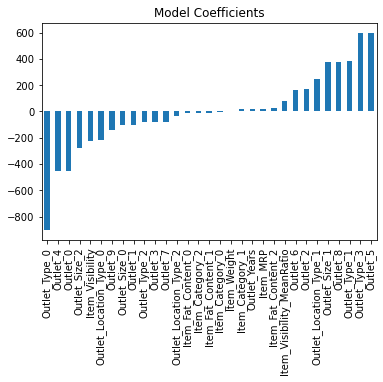

In [100]:
coef = pd.Series(model_LR.coef_, predictors).sort_values()
coef.plot(kind='bar', title='Model Coefficients')

In [101]:
## Creating Submission File
IDcol.append(target)

## Creating the Outlet_Sales column in test dataset with predicted Sales
bm_test[target] = predicted_test

submission_file = pd.DataFrame({x: bm_test[x] for x in IDcol})
submission_file.to_csv('BM_Sales_LR_Model_Prediction.csv', index = False)

C:\Users\Dell\AppData\Local\Temp/ipykernel_8364/144054976.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bm_test[target] = predicted_test


In [102]:
submission_file

,Item_Identifier,Outlet_Identifier,Item_Outlet_Sales
8523,FDW58,OUT049,1852.999626
8524,FDW14,OUT017,1579.625303
8525,NCN55,OUT010,1888.446601
8526,FDQ58,OUT017,2609.313727
8527,FDY38,OUT027,5179.228541
...,...,...,...
14199,FDB58,OUT046,2303.118799
14200,FDD47,OUT018,2430.119450
14201,NCO17,OUT045,1822.340736
14202,FDJ26,OUT017,3539.419911


### 2. Decision Tree Model

In [47]:
## Importing the Model Library
from sklearn.tree import DecisionTreeRegressor

predictors = [x for x in bm_train.columns if x not in [target]+IDcol]

model_DT = DecisionTreeRegressor(max_depth=15, min_samples_leaf=100)

model_DT.fit(bm_train[predictors], bm_train[target])

## Predicting the Outlet_Sales
predicted_train = model_DT.predict(bm_train[predictors])
predicted_test = model_DT.predict(bm_test[predictors])

In [48]:
## For model Evaluation
from sklearn.metrics import mean_squared_error 

## Evaluating the Mean_squared_error
print("RMSE of train data :", mean_squared_error(bm_train[target], predicted_train)**(0.5))

RMSE of train data : 1057.6934941675377


The Decision Tree model improved the mean square error better than Linear Regression Model.  Now let us create the submission file.

In [49]:
## Creating Submission File
IDcol.append(target)

## Creating the Outlet_Sales column in test dataset with predicted Sales
bm_test[target] = predicted_test

submission_file = pd.DataFrame({x: bm_test[x] for x in IDcol})
submission_file.to_csv('BM_Sales_DT_Model_Prediction.csv', index = False)


C:\Users\admin\AppData\Local\Temp/ipykernel_28372/4118551348.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bm_test[target] = predicted_test


### 3. Random Forest Model

In [52]:
## Importing the model
from sklearn.ensemble import RandomForestRegressor

predictors = [x for x in bm_train.columns if x not in [target]+IDcol]

## Creating an object for RandomForestRegressor
model_RFR = RandomForestRegressor(n_estimators=500,max_depth=9, min_samples_leaf=75,n_jobs=5)

## Fitting the model
model_RFR.fit(bm_train[predictors],bm_train[target])

## Predicting the Outlet_Sales
predicted_train_RFR = model_RFR.predict(bm_train[predictors])
predicted_test_RFR = model_RFR.predict(bm_test[predictors])

## For model Evaluation
from sklearn.metrics import mean_squared_error 

## Evaluating the Mean_squared_error
print("RMSE of train data :", mean_squared_error(bm_train[target], predicted_train_RFR)**(0.5))

RMSE of train data : 1052.6476167090948


In [53]:
## Creating Submission File
IDcol.append(target)

## Creating the Outlet_Sales column in test dataset with predicted Sales
bm_test[target] = predicted_test_RFR

submission_file = pd.DataFrame({x: bm_test[x] for x in IDcol})
submission_file.to_csv('BM_Sales_RFR_Model_Prediction.csv', index = False)

C:\Users\Dell\AppData\Local\Temp/ipykernel_11336/2329455591.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bm_test[target] = predicted_test_RFR


<AxesSubplot:>

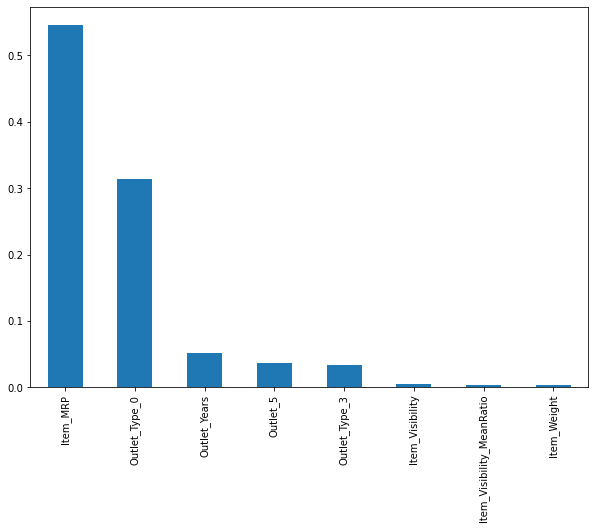

In [54]:
## Importing Matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## Plotting 7 most important features or variables
plt.figure(figsize=(10,7))

feat_importance = pd.Series(model_RFR.feature_importances_, index=bm_train[predictors].columns)

feat_importance.nlargest(8).plot(kind='bar')

In [66]:
## Refined predictors
predictors = ['Item_MRP','Outlet_Type_0','Outlet_Years','Item_Weight','Outlet_5','Outlet_Type_3','Item_Visibility_MeanRatio']

bm_train_FS=bm_train[predictors]
bm_test_FS=bm_test[predictors]

## Creating an object for RandomForestRegressor
model_RFR = RandomForestRegressor(max_depth=9, random_state=100)

## Fitting the model
model_RFR.fit(bm_train_FS[predictors],bm_train[target])

## Predicting the Outlet_Sales
predicted_train_RFR = model_RFR.predict(bm_train_FS[predictors])
predicted_test_RFR = model_RFR.predict(bm_test_FS[predictors])

## For model Evaluation
from sklearn.metrics import mean_squared_error 

## Evaluating the Mean_squared_error
print("RMSE of train data :", mean_squared_error(bm_train[target], predicted_train_RFR)**(0.5))


RMSE of train data : 974.2259818964179


In [54]:
## Creating Submission File
IDcol.append(target)

## Creating the Outlet_Sales column in test dataset with predicted Sales
bm_test[target] = predicted_test_RFR

submission_file = pd.DataFrame({x: bm_test[x] for x in IDcol})
submission_file.to_csv('BM_Sales_RFR_Model_Prediction.csv', index = False)

C:\Users\admin\AppData\Local\Temp/ipykernel_28372/2329455591.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bm_test[target] = predicted_test_RFR


### 4. XGBoost Model

In [67]:
## Importing XGBoost Library
import xgboost as xgb

In [88]:
## Initializing the model Algorithm with Parameters  
model_xgb = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)

In [89]:
## Refined predictors
#predictors = ['Item_MRP','Item_Fat_Content_0','Outlet_Years','Item_Weight','Outlet_7','Item_Fat_Content_1',Item_Fat_Content_2'Item_Visibility_MeanRatio']

#predictors = [x for x in bm_train.columns if x not in [target]+IDcol]

predictors = ['Item_MRP','Item_Visibility','Item_Fat_Content_1','Item_Fat_Content_2','Outlet_Years','Item_Weight','Outlet_7','Item_Fat_Content_0','Item_Visibility_MeanRatio']
bm_train_xgb=bm_train[predictors]
bm_test_xgb=bm_test[predictors]

## Fitting the model
model_xgb.fit(bm_train_xgb[predictors],bm_train[target])

## Predicting the Outlet_Sales
predicted_train_xgb = model_xgb.predict(bm_train_xgb[predictors])
predicted_test_xgb = model_xgb.predict(bm_test_xgb[predictors])

## For model Evaluation
from sklearn.metrics import mean_squared_error 

## Evaluating the Mean_squared_error
print("RMSE of train data :", mean_squared_error(bm_train[target], predicted_train_xgb)**(0.5))

RMSE of train data : 793.2202803779062


In [ ]:
## Creating Submission File
IDcol.append(target)

## Creating the Outlet_Sales column in test dataset with predicted Sales
bm_test[target] = predicted_test_RFR

submission_file = pd.DataFrame({x: bm_test[x] for x in IDcol})
submission_file.to_csv('BM_Sales_XGB_Model_Prediction.csv', index = False)

In [ ]:
xgb.plot_importance(model_xgb)

### 5. XGBoost with base learners

In [73]:
predictors = ['Item_MRP','Item_Visibility','Item_Fat_Content_1','Item_Fat_Content_2','Outlet_Years','Item_Weight','Outlet_7','Item_Fat_Content_0','Item_Visibility_MeanRatio']

In [74]:
X = bm_train[predictors]
y = bm_train[target]

In [75]:
bm_xgb_train_matrix = xgb.DMatrix(data=X, label=y)

In [76]:
params = {"booster":"gblinear","objective":"reg:squarederror"}

In [77]:
bm_reg = xgb.train(dtrain = bm_xgb_train_matrix, params=params, num_boost_round = 5)

In [78]:
pred = bm_reg.predict(bm_xgb_train_matrix)

In [79]:
# Compute and print the RMSE
rmse = np.sqrt(mean_squared_error(y,pred))
print("RMSE: %f" % (rmse))

RMSE: 1421.990678


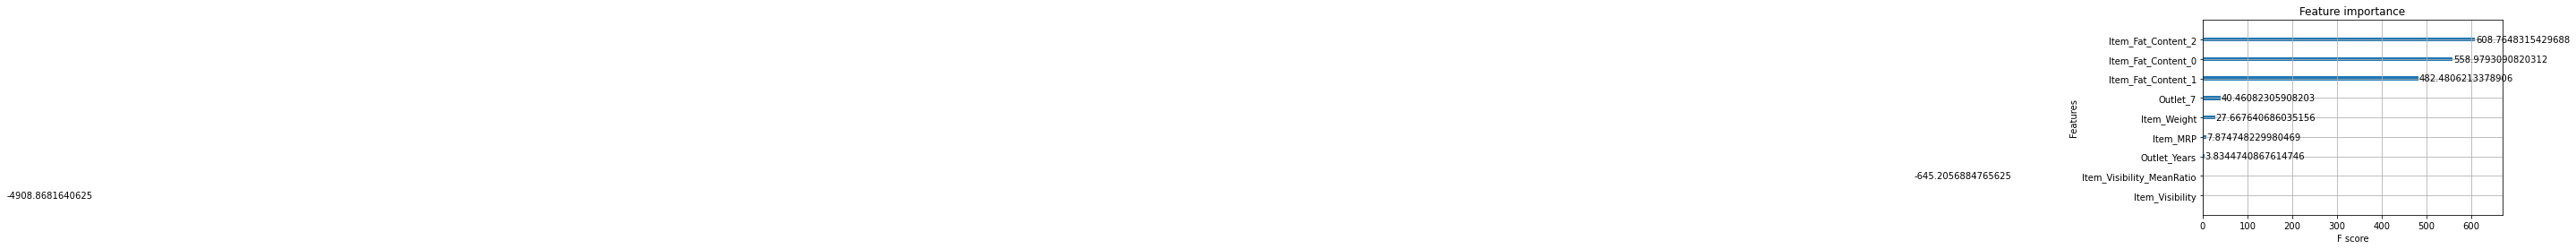

In [104]:
xgb.plot_importance(bm_reg)
plt.show()

### With XGBoost and CV

In [105]:
# Create the parameter dictionary: params
params = {"objective":"reg:squarederror", "max_depth":4}

# Perform cross-validation: cv_results
cv_results = xgb.cv(dtrain=bm_xgb_train_matrix, params=params, nfold=5, num_boost_round=200, metrics="rmse", as_pandas=True, seed=123)

# Print cv_results
print(cv_results)

# Extract and print final boosting round metric
print((cv_results["test-rmse-mean"]).tail(1))

     train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0        2099.600195       13.170598     2101.824853      63.903996
1        1671.838013        9.481145     1677.983838      57.789939
2        1412.246191        7.370745     1421.846631      50.890707
3        1263.348242        5.888239     1276.128784      44.787338
4        1181.238892        5.611021     1197.636817      39.369031
..               ...             ...             ...            ...
195       772.311133        5.834652     1184.059644      18.542621
196       771.195276        5.457535     1184.467627      18.769599
197       770.415881        5.461600     1184.761108      18.550387
198       769.593909        5.580607     1184.926538      18.539562
199       768.779395        5.316612     1185.108887      18.370124

[200 rows x 4 columns]
199    1185.108887
Name: test-rmse-mean, dtype: float64


### GridSearchCV

In [106]:
from sklearn.model_selection import GridSearchCV

In [107]:
## Predictors

predictors = [x for x in bm_train.columns if x not in [target]+IDcol]
predictors

['Item_Weight',
 'Item_Visibility',
 'Item_MRP',
 'Item_Visibility_MeanRatio',
 'Outlet_Years',
 'Item_Fat_Content_0',
 'Item_Fat_Content_1',
 'Item_Fat_Content_2',
 'Outlet_Location_Type_0',
 'Outlet_Location_Type_1',
 'Outlet_Location_Type_2',
 'Outlet_Size_0',
 'Outlet_Size_1',
 'Outlet_Size_2',
 'Item_Category_0',
 'Item_Category_1',
 'Item_Category_2',
 'Outlet_Type_0',
 'Outlet_Type_1',
 'Outlet_Type_2',
 'Outlet_Type_3',
 'Outlet_0',
 'Outlet_1',
 'Outlet_2',
 'Outlet_3',
 'Outlet_4',
 'Outlet_5',
 'Outlet_6',
 'Outlet_7',
 'Outlet_8',
 'Outlet_9']

In [109]:
X = bm_train[predictors]
y = bm_train[target]

In [112]:
gbm = xgb.XGBRegressor()

In [128]:
# Create the parameter grid: gbm_param_grid
gbm_param_grid = {
    'colsample_bytree': [0.3, 0.5,0.7],
    'n_estimators': [100],
    'max_depth': [2, 5,7,9,11]
}

In [129]:
bm_grid = GridSearchCV(estimator=gbm, param_grid=gbm_param_grid, scoring='neg_mean_squared_error',cv=4, verbose=1)

In [130]:
bm_grid.fit(X,y)

Fitting 4 folds for each of 15 candidates, totalling 60 fits


GridSearchCV(cv=4,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    enable_categorical=False, gamma=None,
                                    gpu_id=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, predictor=None,
                                    random_state=None, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
       

In [131]:
print(bm_grid.best_params_)

{'colsample_bytree': 0.7, 'max_depth': 2, 'n_estimators': 100}


In [132]:
print(bm_grid.best_score_)

-1192945.5716205062


### RandomizedSearchCV

In [134]:
from sklearn.model_selection import RandomizedSearchCV

In [144]:
gbm_param_grid = {
    'n_estimators': [25,50],
    'max_depth': range(2, 12),
    'colsample_bytree':[0.3,0.4,0.5,0.6,0.7]
}

In [145]:
gbm = xgb.XGBRegressor(n_estimators=10)

In [147]:
# Perform random search: grid_mse
randomized_mse = RandomizedSearchCV(estimator=gbm,param_distributions=gbm_param_grid, scoring='neg_mean_squared_error', n_iter=5,cv=4,verbose=1)


# Fit randomized_mse to the data
randomized_mse.fit(X,y)

# Print the best parameters and lowest RMSE
print("Best parameters found: ", randomized_mse.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(randomized_mse.best_score_)))

Fitting 4 folds for each of 5 candidates, totalling 20 fits
Best parameters found:  {'n_estimators': 50, 'max_depth': 3, 'colsample_bytree': 0.3}
Lowest RMSE found:  1088.0860240442905


NameError: name 'correlation' is not defined